In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Cargar dataset

In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("marcpaulo/sensor-data")

print("Path to dataset files:", path)

Path to dataset files: /home/angiea/.cache/kagglehub/datasets/marcpaulo/sensor-data/versions/1


In [46]:
data_raw = pd.read_csv(path + "/sensor_data.csv")
data_raw.head()

,time,SensorA,SensorB,SensorC
0,00:00,1.416250,4.219930,3.139646
1,00:01,3.534439,NaN,3.064088
2,00:02,5.659733,NaN,2.925565
3,00:03,5.640167,3.073650,5.381210
4,00:04,4.454474,1.554044,1.055965


In [47]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     1440 non-null   object 
 1   SensorA  1303 non-null   float64
 2   SensorB  1205 non-null   float64
 3   SensorC  1392 non-null   float64
dtypes: float64(3), object(1)
memory usage: 45.1+ KB


In [48]:
data_raw['time'] = pd.to_datetime(data_raw['time'])
data_raw.set_index('time', inplace=True)

/tmp/ipykernel_98665/2152015734.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['time'] = pd.to_datetime(data_raw['time'])


In [49]:
data_raw = data_raw.interpolate(method='time')


## Muestreo

In [50]:
data_digitized = data_raw[['SensorA']].resample('1t').mean()

/tmp/ipykernel_98665/3853238150.py:1: FutureWarning: 't' is deprecated and will be removed in a future version, please use 'min' instead.
  data_digitized = data_raw[['SensorA']].resample('1t').mean()


## Cuantizacion

In [51]:

num_levels = 10
min_val = data_digitized['SensorA'].min()
max_val = data_digitized['SensorA'].max()
bins = np.linspace(min_val, max_val, num_levels + 1)
data_digitized['SensorA'] = pd.cut(data_digitized['SensorA'], bins, labels=False, include_lowest=True)

data_digitized['SensorA'] = data_digitized['SensorA'].apply(
    lambda x: (bins[int(x)] + bins[int(x+1)]) / 2 if pd.notna(x) else np.nan
)

In [52]:
def kalman_filter(signal):
    # Implementación del filtro de Kalman (sin cambios)
    n_iter = len(signal)
    sz = (n_iter,)
    Q = 1e-5
    R = 0.1**2
    xhat = np.zeros(sz)
    P = np.zeros(sz)
    xhatminus = np.zeros(sz)
    Pminus = np.zeros(sz)
    K = np.zeros(sz)
    xhat[0] = signal[0]
    P[0] = 1.0
    for k in range(1, n_iter):
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q
        K[k] = Pminus[k] / (Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k] * (signal[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]
    return xhat


In [53]:
def luenberger_observer(signal):
    # Implementación del observador de Luenberger (sin cambios)
    A = np.array([[0.9]])
    B = np.array([[0.1]])
    C = np.array([[1.0]])
    u = np.zeros(len(signal))
    L = 0.3
    x_hat = np.zeros(len(signal))
    x_hat[0] = signal[0]
    for i in range(1, len(signal)):
        y = signal[i-1]
        x_hat[i] = A.dot(x_hat[i-1]) + B.dot(u[i-1]) + L * (y - C.dot(x_hat[i-1]))
    return x_hat

In [54]:
data_raw['Kalman_Filtered'] = kalman_filter(data_raw['SensorA'].values)
data_raw['Luenberger_Filtered'] = luenberger_observer(data_raw['SensorA'].values)

/tmp/ipykernel_98665/2614181020.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat[i] = A.dot(x_hat[i-1]) + B.dot(u[i-1]) + L * (y - C.dot(x_hat[i-1]))


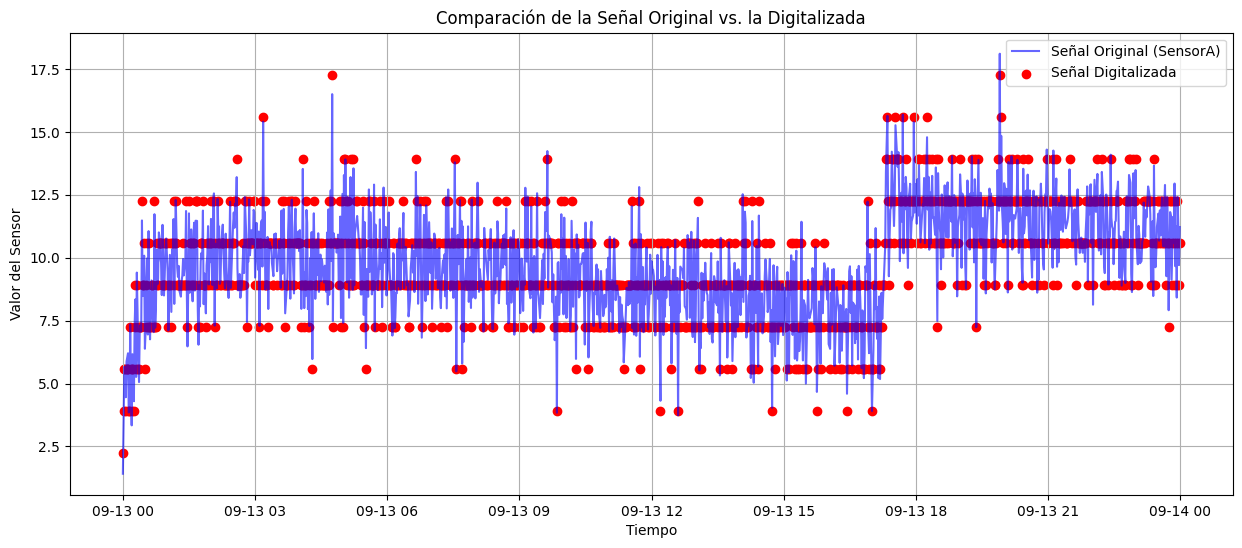

In [55]:
plt.figure(figsize=(15, 6))
plt.plot(data_raw.index, data_raw['SensorA'], label='Señal Original (SensorA)', color='blue', alpha=0.6)
plt.scatter(data_digitized.index, data_digitized['SensorA'], label='Señal Digitalizada', color='red', marker='o')
plt.title('Comparación de la Señal Original vs. la Digitalizada')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True)
plt.show()

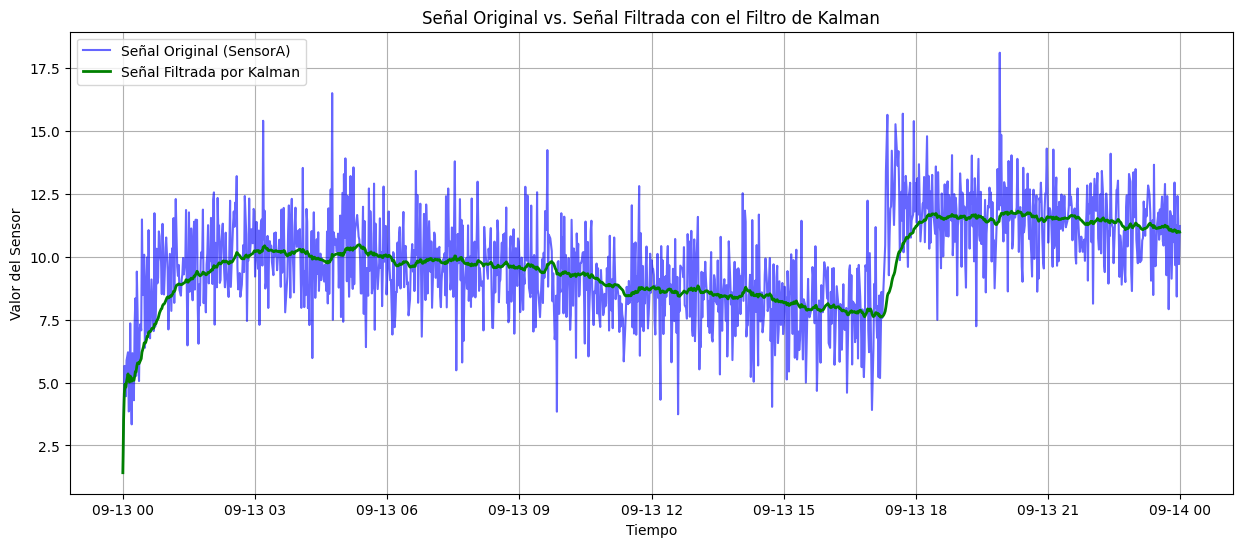

In [56]:
plt.figure(figsize=(15, 6))
plt.plot(data_raw.index, data_raw['SensorA'], label='Señal Original (SensorA)', color='blue', alpha=0.6)
plt.plot(data_raw.index, data_raw['Kalman_Filtered'], label='Señal Filtrada por Kalman', color='green', linewidth=2)
plt.title('Señal Original vs. Señal Filtrada con el Filtro de Kalman')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True)
plt.show()

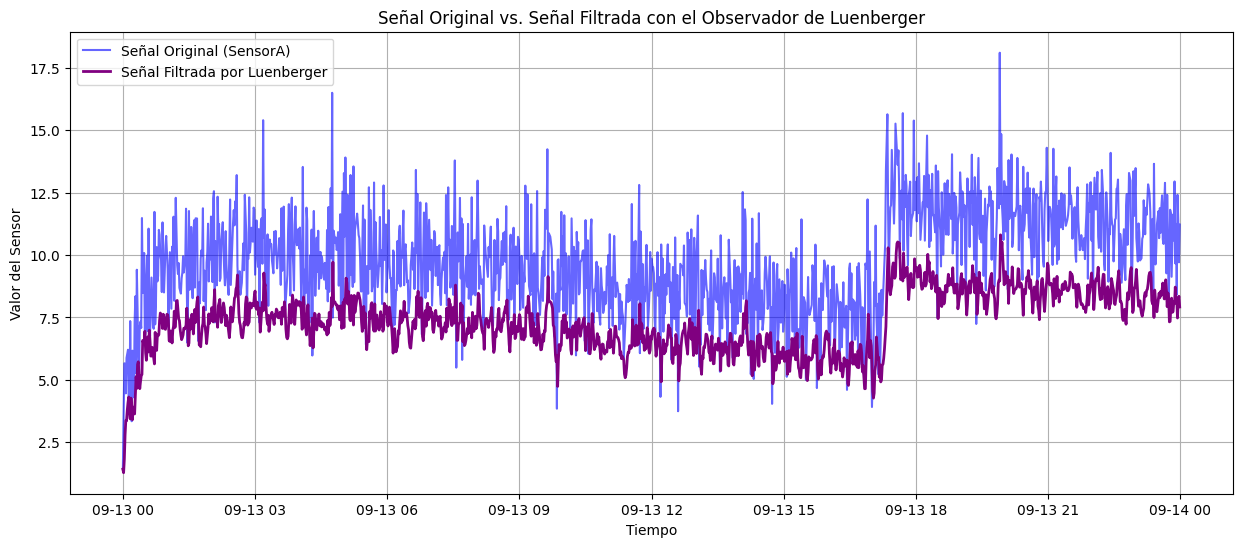

In [57]:
plt.figure(figsize=(15, 6))
plt.plot(data_raw.index, data_raw['SensorA'], label='Señal Original (SensorA)', color='blue', alpha=0.6)
plt.plot(data_raw.index, data_raw['Luenberger_Filtered'], label='Señal Filtrada por Luenberger', color='purple', linewidth=2)
plt.title('Señal Original vs. Señal Filtrada con el Observador de Luenberger')
plt.xlabel('Tiempo')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True)
plt.show()